# ***Set Parameters to define model etc***

In [ ]:
#### Undersampling Possoin_Real:#####
Undersampling = "Possoin_Real" # Options: Regular or Possoin, w, Possoin_Real Regular_Real
Sampling_Mask = "Complementary_Masks" #Options: Single_Combination or One_Mask Complementary_Masks
AF = 5#  acceleration factor

#### Model Input and Output ####
GT_Data = "LowRank" # Options: FullRank LowRank for GROUNDTRUTH!
Low_Rank_Input = True ## apply low rank to the input as well if True
trancuate_t = 96 # set this parameter to control at which time step you stop using the signal

####M Model Parameters ####
batch_size=64

#### Parameters for which axes to choose as Model input and output
DOMAIN = "zfT"  # Input axes that goes into the network (as well as output), 
            # valid options: kzfT (this means k_z in kspace); zfT; ztT; xyz; xzT

In [2]:
import os
import sys

sys.path.append('../scripts')
sys.path.append('../models')

os.environ["CUDA_VISIBLE_DEVICES"]= '1' #, this way I would choose GPU 3 to do the work

import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom # for compressing images / only for testing purposes to speed up NN training
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
import torch.nn as nn
from data_preparation import *
from data_undersampling import *
from output_statistics import *
from data_augmentation import *

from interlacer_layer_modified import *
from Residual_Interlacer_modified import *
from skimage.metrics import structural_similarity as ssim 

#### Model import correct model
from W_net import * #from Naive_CNN_3D_Residual_No_Batch_Norm import *

grouped_time_steps = 1 # Set how many subsequent time steps you want to give to the network at once. Values allowed: 1, 2, 4, 8 (because it has to divide 8)

In [3]:
ground_truth_path = "../data/Ground_Truth/Full_Rank/Full_Rank_All.npy"

#### Define Input Data path
undersampled_data_path = "../data/Undersampled_Data/"+Undersampling+f'/AF_{AF}/'+Sampling_Mask+'/data.npy'

#### Definie Model path
if GT_Data == "FullRank":
    saved_model_path = f"../saved_models/W_net_3D/"+DOMAIN+"/Full2Full/"+Undersampling+f'/AF_{AF}/'+f'Truncate_t_{trancuate_t}/'+Sampling_Mask+f'/best_model.pth'
elif GT_Data == "LowRank":
    saved_model_path = f"../saved_models/W_net_3D/"+DOMAIN+"/Low2Low/"+Undersampling+f'/AF_{AF}/'+f'Truncate_t_{trancuate_t}/'+Sampling_Mask+f'/best_model.pth'
    
# if not os.path.exists(saved_model_path):
#     raise FileNotFoundError(f"Error: The path '{saved_model_path}' does not exist.")
    
#### load data!
Ground_Truth = np.load(ground_truth_path)
Undersampled_Data = np.load(undersampled_data_path)
MASKS = np.load("../data/masks.npy")

if Low_Rank_Input:
    for i in range(0,6):
        Undersampled_Data[...,i] = low_rank(Undersampled_Data[...,i], 8)
        if GT_Data == "LowRank":
            Ground_Truth[...,i] = low_rank(Ground_Truth[...,i], 8)
    
###normalize entire 5D volumes volumes 
for i in range(0,6):
    Ground_Truth[...,i] = Ground_Truth[...,i]/np.max(np.abs(Ground_Truth[...,i]))
    Undersampled_Data[...,i] = Undersampled_Data[...,i]/np.max(np.abs(Undersampled_Data[...,i]))


####
mask_expanded = MASKS[:, :, :, None, None, :]  # Now shape is (22,22,21,1,1,6)
# Use broadcasting to "repeat" the mask along these new axes:
mask_extended = np.broadcast_to(mask_expanded, (22, 22, 21, 96, 8, 6))
mask_extended = mask_extended + 1J*mask_extended

#### additionally make LowRank 8 transformation on input of network, this improves the error significantly!

    
#### trancuate spectral dimension with trancuate_t
Ground_Truth, Undersampled_Data, mask_extended = Ground_Truth[:,:,:,:trancuate_t,:,:], Undersampled_Data[:,:,:,:trancuate_t,:,:], mask_extended[:,:,:,:trancuate_t,:,:]  

### Pad spatial dimensions from 22,22,21 to 24,24,24 which is necessary for U-Net (needs to be divisible by 8 due to downsampling)
pad_width = ((1, 1), (1, 1), (1, 2),(0, 0), (0, 0), (0, 0))    

Ground_Truth = np.pad(Ground_Truth, pad_width, mode='constant', constant_values=0)
Undersampled_Data = np.pad(Undersampled_Data, pad_width, mode='constant', constant_values=0)
mask_extended = np.pad(mask_extended, pad_width, mode='constant', constant_values=0)
    
if DOMAIN == "kzfT":     
    ### spectral transformaton
    Undersampled_Data = np.fft.fftshift(np.fft.fft(Undersampled_Data, axis=-3), axes=-3)
    Ground_Truth = np.fft.fftshift(np.fft.fft(Ground_Truth, axis=-3), axes=-3)    
    #### trafo to k-space
    Undersampled_Data = np.fft.fftshift(np.fft.fft(Undersampled_Data, axis=3), axes=3)
    Ground_Truth = np.fft.fftshift(np.fft.fft(Ground_Truth, axis=3), axes=3) 
    #### reshap vectors
    reshape_vector = (2, 3, 4, 0, 1, 5)
    inverse_reshape = (3, 4, 0, 1, 2, 5)
    
elif DOMAIN == "zfT":
    ### spectral transformaton
    Undersampled_Data = np.fft.fftshift(np.fft.fft(Undersampled_Data, axis=-3), axes=-3)
    Ground_Truth = np.fft.fftshift(np.fft.fft(Ground_Truth, axis=-3), axes=-3)   
    #### reshap vectors
    reshape_vector = (2, 3, 4, 0, 1, 5)
    inverse_reshape = (3, 4, 0, 1, 2, 5)
    
elif DOMAIN == "ztT":   
    #### reshap vectors
    reshape_vector = (2, 3, 4, 0, 1, 5)
    inverse_reshape = (3, 4, 0, 1, 2, 5)
    
elif DOMAIN == "xyz":   
    #### reshap vectors
    reshape_vector = (0, 1, 2, 3, 4, 5)
    inverse_reshape = (0, 1, 2, 3, 4, 5)
    
elif DOMAIN == "xzT":   
    #### reshap vectors
    reshape_vector = (0, 2, 4, 3, 1, 5)
    inverse_reshape = (0, 4, 1, 3, 2, 5)
    
else: 
    raise Exception("No valid Domain chosen!")
    
#### Reshaping !
Undersampled_Data, Ground_Truth, mask_extended = Undersampled_Data.transpose(reshape_vector) , Ground_Truth.transpose(reshape_vector), mask_extended.transpose(reshape_vector)  
original_shape = Ground_Truth.copy().shape

In [4]:
#### Train_Test_Split ####
ground_truth = Ground_Truth

#### Assign undersampled network input ####
NN_input = Undersampled_Data

Mask =  mask_extended

# #### Collapse ununsed dimensions ####
ground_truth = ground_truth.reshape(Ground_Truth.shape[0], Ground_Truth.shape[1], Ground_Truth.shape[2], -1)
NN_input = NN_input.reshape(Ground_Truth.shape[0], Ground_Truth.shape[1], Ground_Truth.shape[2], -1)
Mask = Mask.reshape(Ground_Truth.shape[0], Ground_Truth.shape[1], Ground_Truth.shape[2], -1)

#### Normalize data #####
#normalized_input, normalized_ground_truth, norm_values = normalize_data_per_image_new(NN_input, ground_truth)

#### reshape for pytorch ####
data, labels, Mask  = reshape_for_pytorch(NN_input, grouped_time_steps), reshape_for_pytorch(ground_truth, grouped_time_steps), reshape_for_pytorch(Mask, grouped_time_steps)

In [14]:

# Create TensorDataset instances
dataset = TensorDataset(data, labels, Mask)

# Create DataLoaders
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  # Number of convolutional layers
model = WNet3D().to(device)

#saved_model_path = "../saved_models/Naive_CNN_3D_AF_3_Non_Residual/5Layer/model.pth"  # Replace with your file path

# 2. Load the model's state_dict (weights) from the saved file

checkpoint = torch.load(saved_model_path, map_location=device)
# Extract the model state_dict
model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [6]:
# #### Define Input Data path
GM_mask = np.load("../data/fn_vb_DMI_CRT_P08/GM_mask.npy")
GM_mask = GM_mask[:,:,:,np.newaxis,np.newaxis]

#### load data back to its original format
#### load data!
Ground_Truth = np.load(ground_truth_path)
Undersampled_Data = np.load(undersampled_data_path)
MASKS = np.load("../data/masks.npy")

if Low_Rank_Input:
    for i in range(0,6):
        Undersampled_Data[...,i] = low_rank(Undersampled_Data[...,i], 8)
        if GT_Data == "LowRank":
            Ground_Truth[...,i] = low_rank(Ground_Truth[...,i], 8)
    
###normalize entire 5D volumes volumes 
for i in range(0,6):
    Ground_Truth[...,i] = Ground_Truth[...,i]/np.max(np.abs(Ground_Truth[...,i]))
    Undersampled_Data[...,i] = Undersampled_Data[...,i]/np.max(np.abs(Undersampled_Data[...,i]))

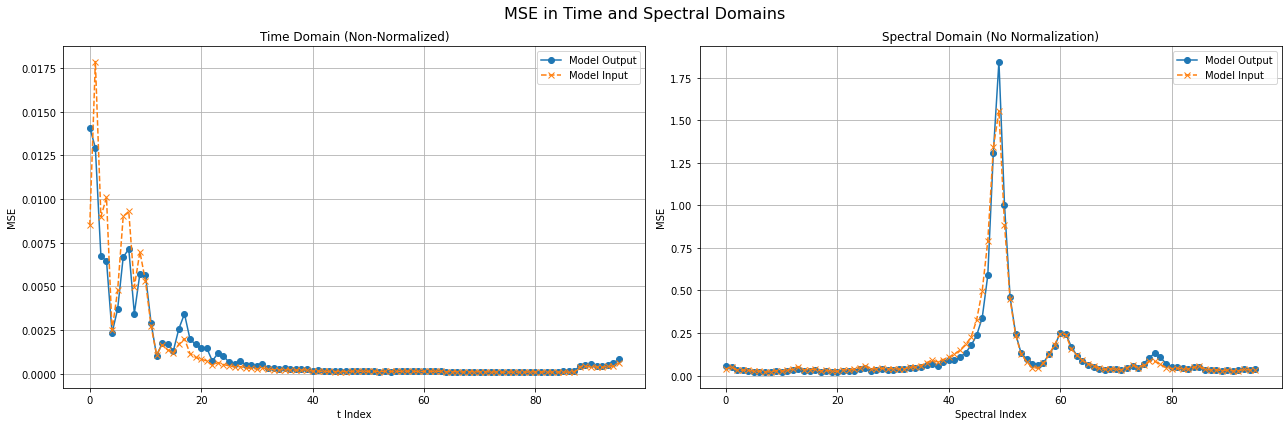

==== Model Output vs Ground Truth ====
Total MSE in image domain: 0.000606995204874308
Normalized Total MSE in image domain: 0.000606995204874308
Total MSE in spectral domain: 0.058271539667933546

==== Model Input vs Ground Truth ====
Total MSE in image domain: 0.0006223001500754437
Normalized Total MSE in image domain: 0.0006223001500754437
Total MSE in spectral domain: 0.0597408144072426


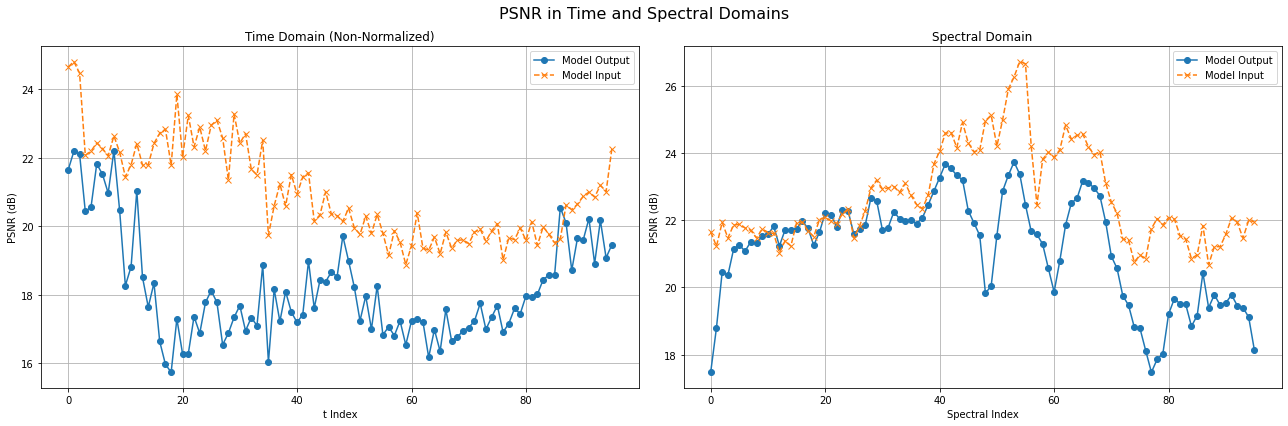

==== Model Output vs. Ground Truth ====
Average PSNR in image domain:    18.16136134962986
Average PSNR in frequency domain: 21.15008100096325

==== Model Input vs. Ground Truth ====
Average PSNR in image domain:    21.007294778392257
Average PSNR in frequency domain: 22.709505765157257


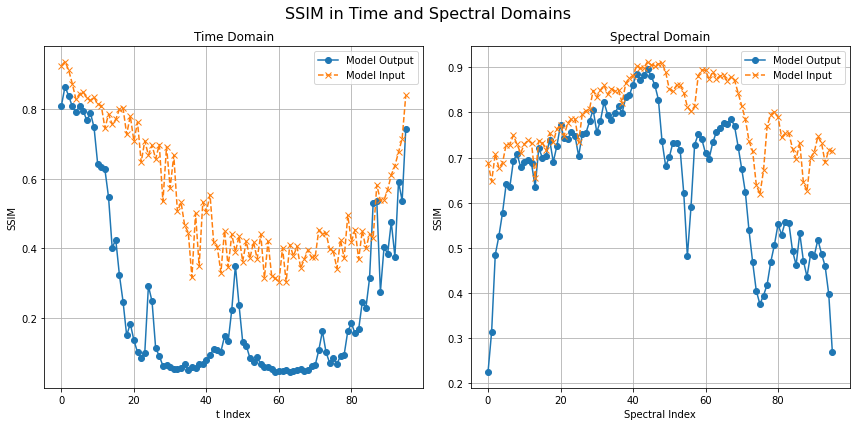

==== Model Output vs. Ground Truth ====
Average SSIM in image domain:    0.25174876317345996
Average SSIM in frequency domain: 0.6592194365055226

==== Model Input vs. Ground Truth ====
Average SSIM in image domain:    0.5479925349577331
Average SSIM in frequency domain: 0.7891982901642871


In [15]:
norm_values = np.ones((data.shape[0]))

Model_Outputs_Test_Set = evaluate_WNet(model, data_loader, device, inverse_reshape_for_pytorch, norm_values, original_shape, inverse_reshape, grouped_time_steps)

Test_Set = 5

if DOMAIN == "kzfT":
    Model_Outputs_Test_Set = np.fft.ifft(np.fft.ifftshift(Model_Outputs_Test_Set, axes=-3), axis=-3)  ## go back to kz->z, f->t
    Model_Outputs_Test_Set = np.fft.ifft(np.fft.ifftshift(Model_Outputs_Test_Set, axes=3), axis=3)
    
elif DOMAIN == "zfT":
    Model_Outputs_Test_Set = np.fft.ifft(np.fft.ifftshift(Model_Outputs_Test_Set, axes=-3), axis=-3)  ## f->t
    
Model_Outputs_Test_Set = Model_Outputs_Test_Set[..., Test_Set]    
    
ground_truth = Ground_Truth[...,Test_Set]

mask = np.load('../data/masks.npy')
mask_5 = mask[:,:,:,Test_Set]
mask_5D = mask_5[:,:,:, np.newaxis, np.newaxis]

Model_Outputs_Test_Set = Model_Outputs_Test_Set*mask_5D#*GM_mask
ground_truth = ground_truth*mask_5D#*GM_mask
norm_values_test = np.ones((trancuate_t,8))
### to be fair, I compute a LR approximation, as a trivial baseline comparison + apply the mask
model_input = Undersampled_Data[...,Test_Set]*mask_5D#*GM_mask
model_input = model_input[:,:,:,:trancuate_t,:]


# # #### NORMALIZE!
# model_input = model_input/np.mean(np.max(np.abs(model_input), axis=(0,1,2)))   
# Model_Outputs_Test_Set = Model_Outputs_Test_Set/np.mean(np.max(np.abs(Model_Outputs_Test_Set), axis=(0,1,2)))   
# ground_truth = ground_truth/np.mean(np.max(np.abs(ground_truth), axis=(0,1,2))) 
# # #### NORMALIZE END!

plot_general_statistics(Model_Outputs_Test_Set, model_input, ground_truth, trancuate_t, norm_values_test, label = "Model Output", label2 = "Model Input")
plot_general_statistics_PSNR(Model_Outputs_Test_Set, model_input, ground_truth, trancuate_t, norm_values_test, label = "Model Output", label2 = "Model Input")
plot_general_statistics_SSIM(Model_Outputs_Test_Set, model_input, ground_truth, trancuate_t, norm_values_test, label = "Model Output", label2 = "Model Input")

/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:160: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)
../scripts/output_statistics.py:283: RuntimeWarning: invalid value encountered in double_scalars
  return calculate_rmse(pred, gt) / (gt.max() - gt.min())


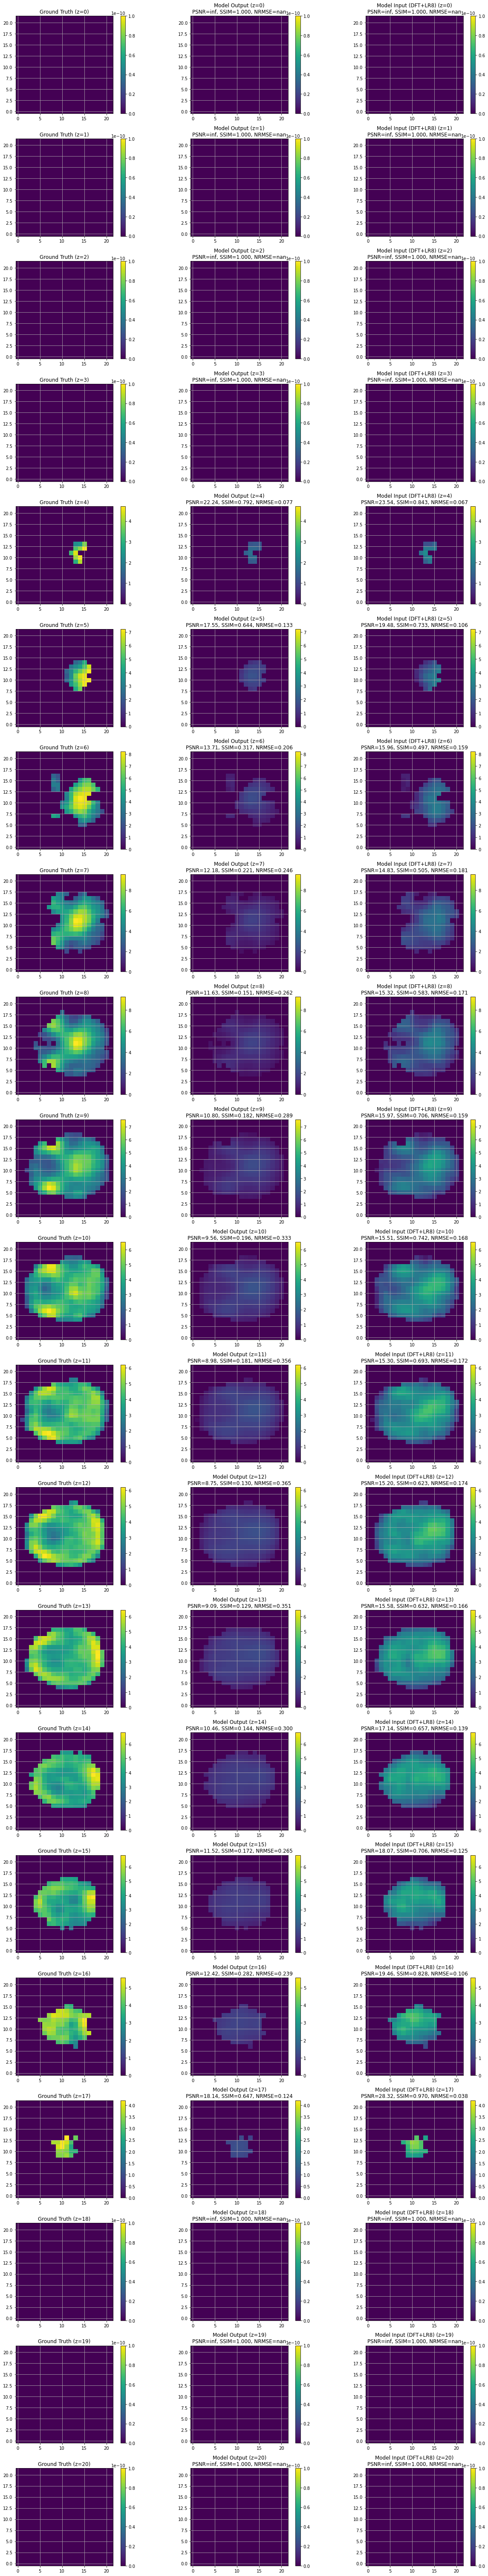

In [9]:
tf = 50 #50 = Water, 61 Glucose, 24 Glx
T = 7

comparison_Plot_3D_vs_Ifft(Model_Outputs_Test_Set, ground_truth, model_input, tf, T, domain="spectral", label = "Model Output", label2 = "Model Input (DFT+LR8)", label3="Ground Truth", fixed_scale = True)

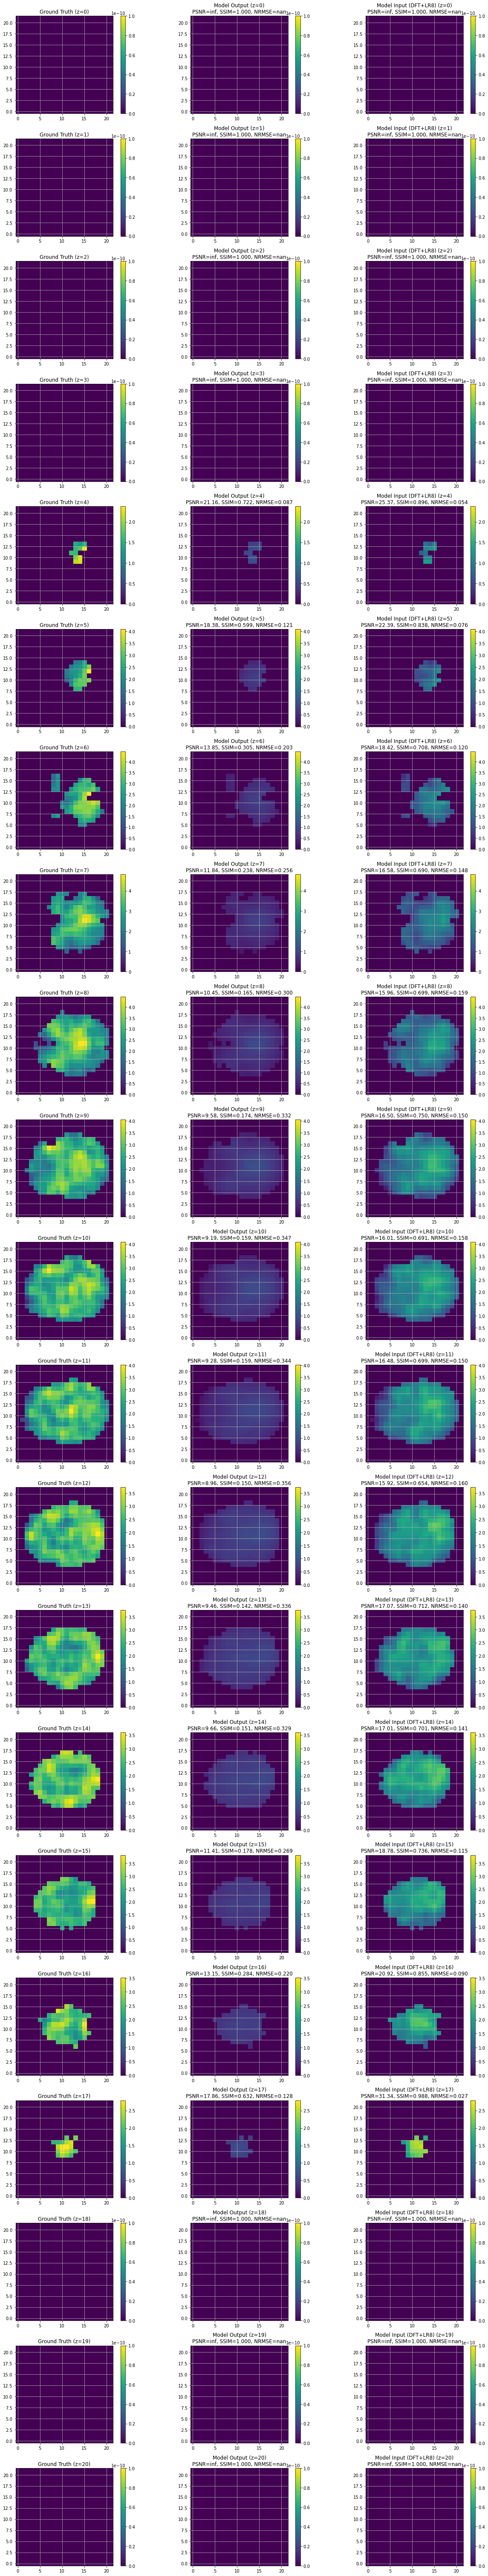

In [10]:
tf = 61 #50 = Water, 61 Glucose, 24 Glx
T = 7

comparison_Plot_3D_vs_Ifft(Model_Outputs_Test_Set, ground_truth, model_input, tf, T, domain="spectral", label = "Model Output", label2 = "Model Input (DFT+LR8)", label3="Ground Truth", fixed_scale = True)

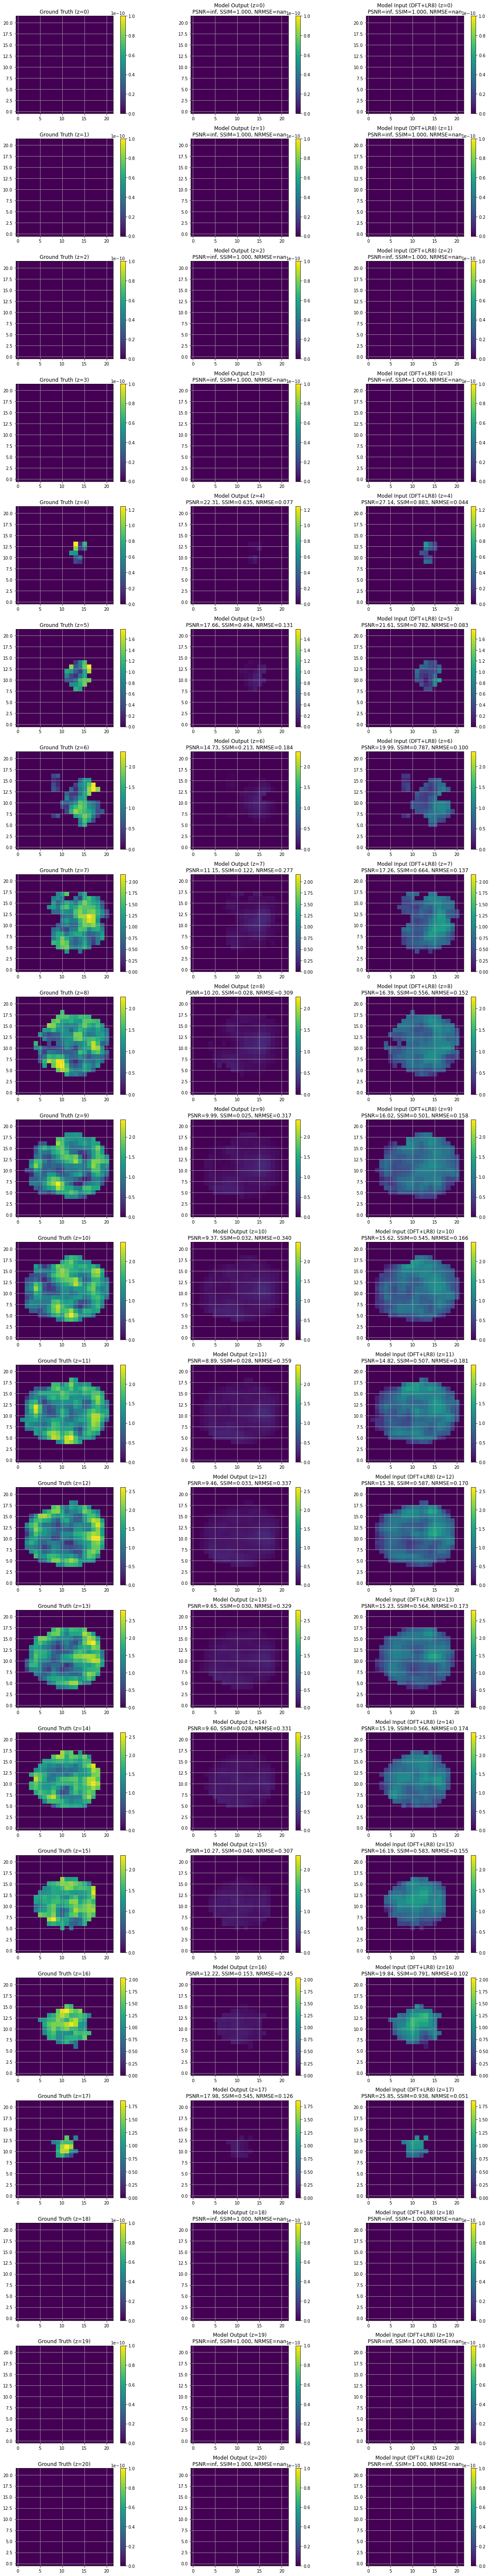

In [11]:
tf = 78 #50 = Water, 61 Glucose, 24 Glx
T = 7

comparison_Plot_3D_vs_Ifft(Model_Outputs_Test_Set, ground_truth, model_input, tf, T, domain="spectral", label = "Model Output", label2 = "Model Input (DFT+LR8)", label3="Ground Truth", fixed_scale = True)

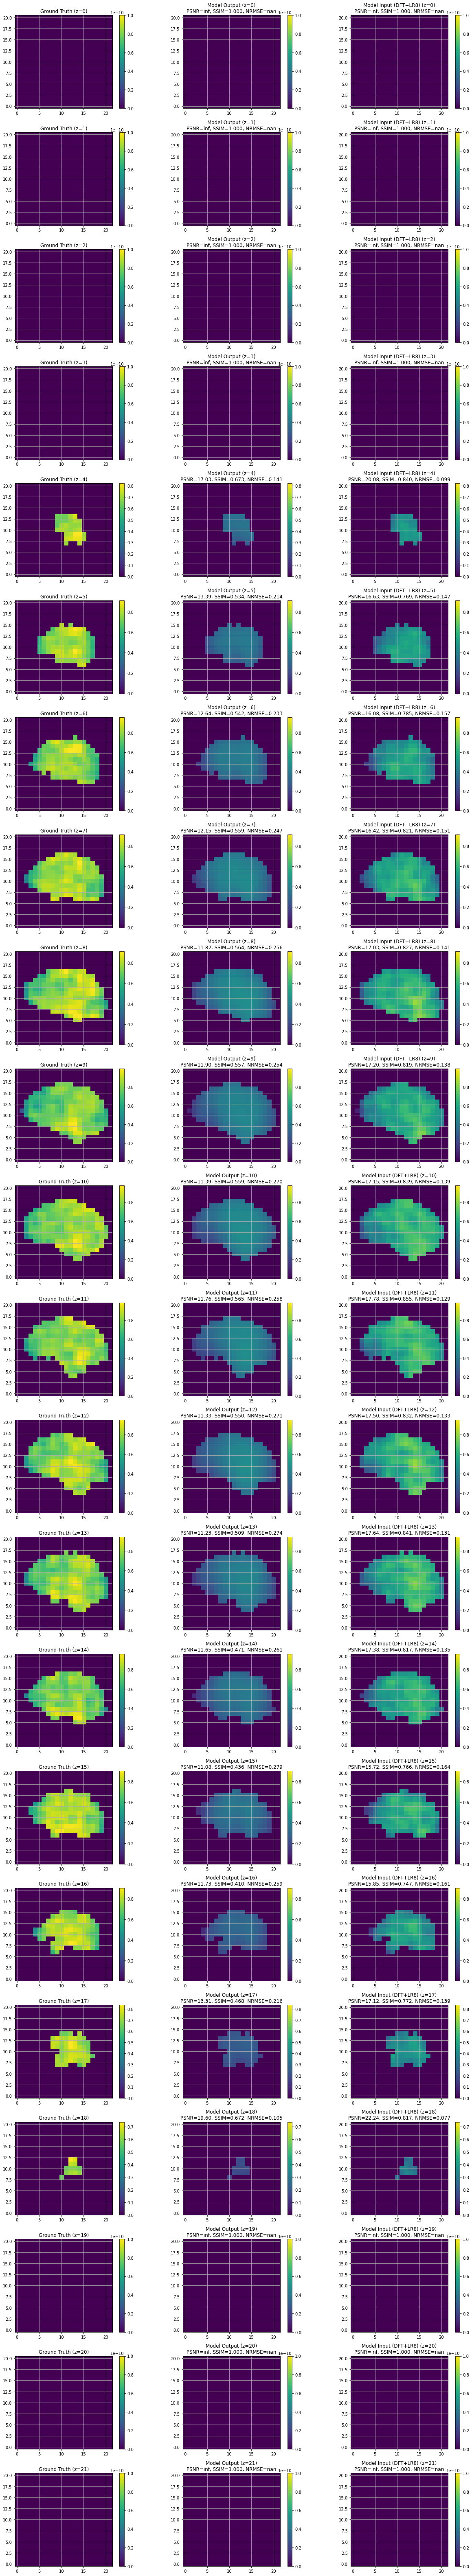

In [12]:
t = 1 #50 = Water, 60 Glucose, 24 Glx
T = 7

### NOTE: The labels are off, due to swapping I actually show z-y images along the x axis
ground_truth_swapped = np.swapaxes(ground_truth, 0, 2)
Model_Outputs_Test_Set_swapped = np.swapaxes(Model_Outputs_Test_Set, 0, 2)
model_input_swapped = np.swapaxes(model_input, 0, 2)

comparison_Plot_3D_vs_Ifft(Model_Outputs_Test_Set_swapped, ground_truth_swapped, model_input_swapped, t, T, domain="time", label = "Model Output", label2 = "Model Input (DFT+LR8)", label3="Ground Truth", fixed_scale = True)

In [13]:
ground_truth_spectral = np.fft.fftshift(np.fft.fft(ground_truth, axis=-2), axes=-2)
model_pred_spectral = np.fft.fftshift(np.fft.fft(Model_Outputs_Test_Set, axis=-2), axes=-2)
IFF_LR_8 = np.fft.fftshift(np.fft.fft(model_input, axis=-2), axes=-2)

IFF_LR_8 = np.fft.fftshift(np.fft.fft(model_input, axis=-2), axes=-2)
# Fixed indices for x, y, and T:
# ----------------------------------------------------------------------
# Fixed indices for x, y, and T
# 10
for x_fixed in range(14, 4, -1):
    #x_fixed = 10
    y_fixed = 10
    T_fixed = 7

    num_z = 21  # Number of z slices

    # ----------------------------------------------------------------------
    # Create a figure with 2 columns:
    #   Column 1 -> Absolute value plots
    #   Column 2 -> Residuals (GT - [Others])
    # ----------------------------------------------------------------------
    fig, axes = plt.subplots(nrows=num_z, ncols=2, figsize=(16, num_z * 3.5), sharex=True)

    # If there's only one row, ensure axes is 2D
    if num_z == 1:
        axes = np.array([axes])

    for z in range(num_z):
        # Extract the spectra at [x_fixed, y_fixed, z, :, T_fixed]
        gt_spec  = ground_truth_spectral[x_fixed, y_fixed, z, :, T_fixed]
        mp_spec  = model_pred_spectral[x_fixed, y_fixed, z, :, T_fixed]
        iff_spec = IFF_LR_8[x_fixed, y_fixed, z, :, T_fixed]

        # ------------------------------------------------------------------
        # Column 1: Plot absolute spectra
        # ------------------------------------------------------------------
        ax_abs = axes[z, 0]
        ax_abs.plot(np.abs(gt_spec),  label=f'Ground Truth, x_index = {x_fixed}',    color='blue')
        ax_abs.plot(np.abs(mp_spec),  label=f'Model Prediction, x_index = {x_fixed}',color='orange')
        ax_abs.plot(np.abs(iff_spec), label=f'DFT + LR 8, x_index = {x_fixed}',     color='green')
        #ax_abs.set_ylim(-1, 10)
        # Row label on the Y-axis
        ax_abs.set_ylabel(f'z = {z}')

        if z == 0:
            ax_abs.set_title('Absolute Value')
        ax_abs.legend(loc='upper left')

        # ------------------------------------------------------------------
        # Column 2: Plot residuals (Ground Truth - [Others])
        # ------------------------------------------------------------------
        ax_res = axes[z, 1]

        residual_gt_mp  = np.abs(gt_spec) - np.abs(mp_spec)
        residual_gt_iff = np.abs(gt_spec) - np.abs(iff_spec)

        ax_res.plot(residual_gt_mp,  label=f'GroundTruth - Model, x_index = {x_fixed}',        color='orange')
        ax_res.plot(residual_gt_iff, label=f'GroundTruth - DFT + LR 8, x_index = {x_fixed}',  color='green')

        if z == 0:
            ax_res.set_title('Residual')
        ax_res.legend(loc='upper left')
        ax_res.set_ylim(-1, 10)
        
    plt.tight_layout()
    plt.show()
    print('===================Next x index===========================')

KeyboardInterrupt: 